In [1]:
import pyidi
import os
import numpy as np
import matplotlib.pyplot as plt 
import re
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import ast
from matplotlib.patheffects import Stroke
from mpl_interactions import zoom_factory
warnings.filterwarnings('ignore')


c:\Users\thijsmas\AppData\Local\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [ ]:
# folder_paths = ['D:/HSC', 'F:/', 'C:/Users/thijs/Documents/HSC/', 'H:/My Drive/PHD/HSC']  #, 'H:/My Drive/PHD/HSC'
# sequential_image_n = 0
# file_names = []
# # loop video files
# fix, ax = plt.subplots(1, 3, figsize=(25, 6))
# plt.tight_layout()

# tested_locations = [[], [], []]
# df = pd.DataFrame(columns=['filename', 'ecc', 'loc','mass', 'taut/loose', 'impact/pluck'])
# still_images_mean = np.zeros((3, 512, 1024))
# for folder_path in folder_paths:
#     for root, dirs, files in os.walk(os.path.normpath(folder_path), topdown=False):
#         for file in files:
#             if not file.endswith('.mraw') or not file.startswith('Full_web_') or file.startswith('Full_web_ecc7'):
#                 continue
#             sections = file.split('_')
#             if 'nomass' in sections or 'taut' in sections or 'loose' in sections:
#                 continue
#             file = os.path.splitext(file)[0] + '.cihx'
#             if not file in file_names:
#                 for section in sections:
#                     if section.startswith('ecc'):
#                         n_ax = int(section[-1])
#                     elif section.startswith('Floc'):
#                         n_loc = int(re.findall('\d+', section)[0])
#                 file_names.append(file)
#                 if n_loc not in tested_locations[n_ax]:
#                     tested_locations[n_ax].append(n_loc)
#                     file_path = os.path.join(root, file)
#                     video = pyidi.pyIDI(file_path)
#                     still_image_new = video.mraw[sequential_image_n]
#                     n_images = len(tested_locations[n_ax])
#                     still_images_mean[n_ax] = still_images_mean[n_ax]*(n_images-1)/n_images
#                     still_images_mean[n_ax] += still_image_new*(1/n_images)
#                 n_ax = np.nan
#                 n_loc = np.nan

# for n_ax in range(3):
#     ax[n_ax].imshow(still_images_mean[n_ax], cmap='gray')
# plt.show()
# len(file_names), file_names, tested_locations

In [2]:
folder_paths = ['D:/HSC', 'F:/', 'C:/Users/thijs/Documents/HSC/', 'H:/My Drive/PHD/HSC']  #, 'H:/My Drive/PHD/HSC'
file_names = []
# df = pd.DataFrame(columns=['filename', 'path', 'ecc', 'loc','mass', 'taut/loose', 'impact/pluck', 'version', 'n_frames', 'fps', 'Oversatured pixels', 'Undersatured pixels', 'spider_ij', 'prey_ij'])
df_data = []
for folder_path in folder_paths:
    for root, dirs, files in os.walk(os.path.normpath(folder_path), topdown=False):
        for file in files:
            if not file.endswith('.mraw') or not file.startswith('Full_web_') or file.startswith('Full_web_ecc7'):
                continue
            file = os.path.splitext(file)[0] + '.cihx'
            if file in file_names:
                continue   
            file_names.append(file)
        
            sections = file.split('_')
            version = 0
            for section in sections:
                if section.startswith('ecc'):
                    n_ax = int(section[-1])
                elif section.startswith('Floc'):
                    n_loc = int(re.findall('\d+', section)[0])
                elif section.startswith('v'):
                    version = int(section[1:])

            if 'nomass' in sections:
                mass = False
            else:
                mass = True
            if 'taut' in sections:
                taut_loose = 'Taut'
            elif 'loose' in sections:
                taut_loose = 'Loose'
            else:
                taut_loose = 'Loose'
            if 'impact' in sections:
                impact_pluck = 'Impact'
            elif 'pluck' in sections:
                impact_pluck = 'Pluck'
            else:
                impact_pluck = 'Impact'
            
            file_path = os.path.join(root, file)
            try:
                video = pyidi.pyIDI(file_path)
            except:
                print('Could not open file: ' + file_path)
                continue
            n_frames = video.info['Total Frame']
            fps = video.info['Record Rate(fps)']
            bit_depth = video.info['Color Bit']
            still_image = video.mraw[0]
            height, width = still_image.shape
            start_row = int(height * 0.1)
            end_row = int(height * 0.9)
            start_col = int(width * 0.1)
            end_col = int(width * 0.9)
            cropped_image = still_image[start_row:end_row, start_col:end_col]
            white_indices_n = np.sum(cropped_image >= int(0.99*(2**bit_depth-1)))
            black_indices_n = np.sum(cropped_image <= int(0.01*(2**bit_depth-1)))

            video.close_video()

            df_data.append({'filename': file,
                            'path': file_path,
                            'ecc': n_ax, 
                            'loc': n_loc,
                            'mass': mass,
                            'taut/loose': taut_loose, 
                            'impact/pluck': impact_pluck, 
                            'version': version, 
                            'n_frames': n_frames,
                            'fps': fps,
                            'Oversatured pixels': white_indices_n,
                            'Undersatured pixels': black_indices_n})
            del n_ax, n_loc, mass, taut_loose, impact_pluck, file_path
df = pd.DataFrame(df_data)
df['prey_ij'] = 'not set'
df['spider_ij'] = 'not set'
df.to_csv('H:/My Drive/PHD/HSC/file_descriptions.csv', index=False)

Could not open file: H:\My Drive\PHD\HSC\ecc2\web1\Full_web_ecc2_new2_Floc18_v8_S01\Full_web_ecc2_new2_Floc18_v8_S01.cihx


In [ ]:
def break_event(event):
    """check which points are inside the polygon when the user presses 'enter'
    The points inside the selection are deleted from the ROI
    """
    global _STOP
    if event.key == 'c':
        plt.close()
        _STOP = True
def click_event(event):
    x, y = event.xdata, event.ydata
    if event.button == 1:
         df['prey_ij'][id] = (int(x), int(y))
    elif event.button == 3:
        df['spider_ij'][id] = (int(x), int(y))    

df = pd.read_csv('H:/My Drive/PHD/HSC/file_descriptions_wlocs.csv')
%matplotlib qt
sequential_image_n = 0
_STOP = False
spider_ij = []
prey_ij = []
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
prey_plot, = plt.plot([],[], 'or', markersize=10)
spider_plot, = plt.plot([],[], 'ob', markersize=10)
ax.set_xlabel('left click: prey, right click: spider')
zoom_factory(ax)
fig.canvas.mpl_connect('key_press_event', break_event)
fig.canvas.mpl_connect('button_press_event', click_event)
text = ax.text(0, 5, '', ha='left', va='center', fontdict={'size': 20})
for id, path_temp in enumerate(df['path']):
    if df['prey_ij'][id] != 'not set' and df['spider_ij'][id] != 'not set':
        continue
    video = pyidi.pyIDI(path_temp)
    still_image = video.mraw[sequential_image_n]
    cf = ax.imshow(still_image, cmap='gray')
    if df['prey_ij'][id] != 'not set':
        prey_ij = eval(df['prey_ij'][id])
        prey_plot.set_data(prey_ij[0], prey_ij[1])
    else:
        prey_plot.set_data([],[])
    if df['spider_ij'][id] != 'not set':
        spider_ij = eval(df['spider_ij'][id])
        spider_plot.set_data(spider_ij[0], spider_ij[1])
    else:
        spider_plot.set_data([],[])
    plt.title(df['filename'][id])
    plt.draw()
    plt.waitforbuttonpress()
    del cf 
    if _STOP:
        break
plt.close()
df.to_csv('H:/My Drive/PHD/HSC/file_descriptions_wlocs.csv', index=False)

In [ ]:
# def click_event(event):
#     x, y = event.xdata, event.ydata
#     if event.button == 1:
#          df['prey_ij'][id] = (int(x), int(y))
#     elif event.button == 3:
#         df['spider_ij'][id] = (int(x), int(y))    
# def break_event(event):
#     """check which points are inside the polygon when the user presses 'enter'
#     The points inside the selection are deleted from the ROI
#     """
#     global _STOP
#     if event.key == 'c':
#         plt.close()
#         _STOP = True

# df = pd.read_csv('H:/My Drive/PHD/HSC/file_descriptions.csv')
# %matplotlib qt
# sequential_image_n = 0
# _STOP = False

# fig, ax = plt.subplots(figsize=(10, 10))
# for id, path_temp in enumerate(df['path']):
#     video = pyidi.pyIDI(path_temp)
#     still_image = video.mraw[sequential_image_n]
#     video.close_video()
#     fig.clf()
#     fig.canvas.mpl_connect('button_press_event', click_event)
#     fig.canvas.mpl_connect('key_press_event', break_event)
    
#     plt.title(df['filename'][id])
#     ax.imshow(still_image, cmap='gray')
#     plt.show()
#     if _STOP:
#         break


In [3]:
# df.to_csv('H:/My Drive/PHD/HSC/file_descriptions_with_locations.csv', index=False)
df_wlocs = pd.read_csv('H:/My Drive/PHD/HSC/file_descriptions_wlocs.csv')
df = pd.merge(df, df_wlocs[['filename', 'spider_ij', 'prey_ij']], on='filename', how='left')

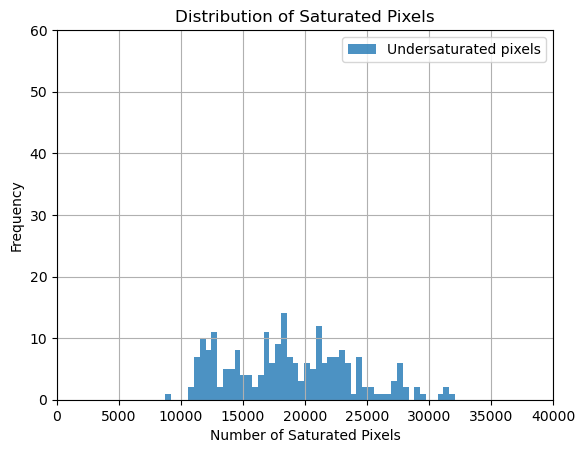

In [7]:
fig, ax = plt.subplots()
# df.hist(column='Oversatured pixels', bins=50, ax=ax, alpha=0.8, label='Oversaturated pixels')
df.hist(column='Undersatured pixels', bins=50, ax=ax, alpha=0.8, label='Undersaturated pixels')
ax.set_title('Distribution of Saturated Pixels')
ax.set_xlabel('Number of Saturated Pixels')
ax.set_ylabel('Frequency')
ax.legend()
ax.set_ylim([0, 60])  # set the y-axis limits
ax.set_xlim([0, 40000])  # set the y-axis limits
plt.show()


In [6]:
df = pd.read_csv('H:/My Drive/PHD/HSC/file_descriptions_wlocs.csv')
df

,filename,path,ecc,loc,mass,taut/loose,impact/pluck,version,n_frames,fps,Oversatured pixels,Undersatured pixels,prey_ij,spider_ij
0,Full_web_ecc1_new_Floc1_nomass_v0_S01.cihx,H:\My Drive\PHD\HSC\ecc1\web0\no_mass\Full_web...,1,1,False,Loose,Impact,0,10000,8000.0,0,17843,"(727, 300)","(526, 181)"
1,Full_web_ecc1_new_Floc8_nomass_v0_S01.cihx,H:\My Drive\PHD\HSC\ecc1\web0\no_mass\Full_web...,1,8,False,Loose,Impact,0,10000,8000.0,0,22787,"(767, 229)","(526, 181)"
2,Full_web_ecc1_new_Floc2_nomass_v0_S01.cihx,H:\My Drive\PHD\HSC\ecc1\web0\no_mass\Full_web...,1,2,False,Loose,Impact,0,10000,8000.0,66,14313,"(648, 147)","(526, 181)"
3,Full_web_ecc1_new_Floc9_nomass_v0_S01.cihx,H:\My Drive\PHD\HSC\ecc1\web0\no_mass\Full_web...,1,9,False,Loose,Impact,0,10100,8000.0,36655,8711,"(514, 95)","(526, 181)"
4,Full_web_ecc1_new_Floc9_nomass_v1_S01.cihx,H:\My Drive\PHD\HSC\ecc1\web0\no_mass\Full_web...,1,9,False,Loose,Impact,1,10000,8000.0,0,11561,"(514, 94)","(528, 181)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214,Full_web_ecc0_new2_Floc18_v1_S01.cihx,H:\My Drive\PHD\HSC\ecc0\web1\Full_web_ecc0_ne...,0,18,True,Loose,Impact,1,8000,8000.0,48,27781,"(518, 365)","(529, 258)"
215,Full_web_ecc0_new2_Floc19_v0_S01.cihx,H:\My Drive\PHD\HSC\ecc0\web1\Full_web_ecc0_ne...,0,19,True,Loose,Impact,0,8000,8000.0,629,27574,"(520, 394)","(530, 259)"
216,Full_web_ecc0_new2_Floc19_v1_S01.cihx,H:\My Drive\PHD\HSC\ecc0\web1\Full_web_ecc0_ne...,0,19,True,Loose,Impact,1,8000,8000.0,768,27439,"(520, 394)","(530, 259)"
217,Full_web_ecc0_new2_Floc5_v0_S01.cihx,H:\My Drive\PHD\HSC\ecc0\web1\Full_web_ecc0_ne...,0,5,True,Loose,Impact,0,8000,8000.0,9942,20515,"(846, 275)","(533, 259)"


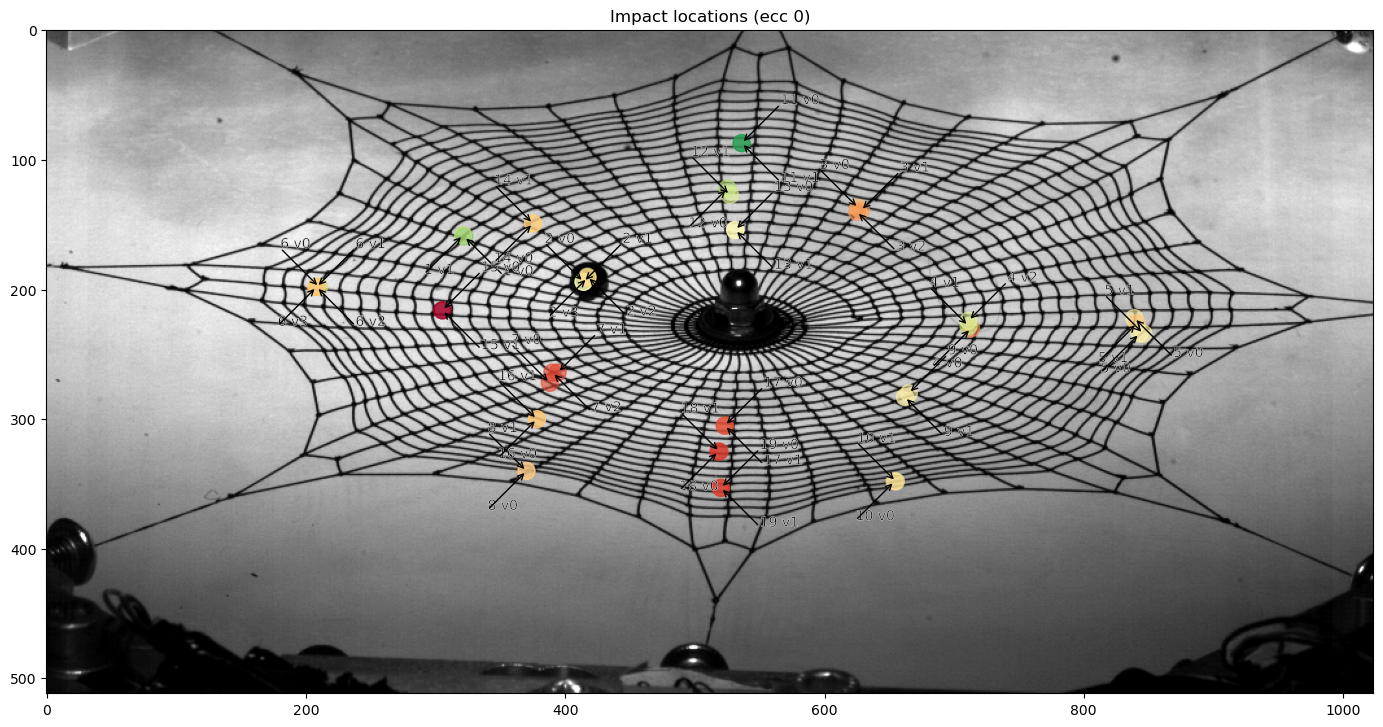

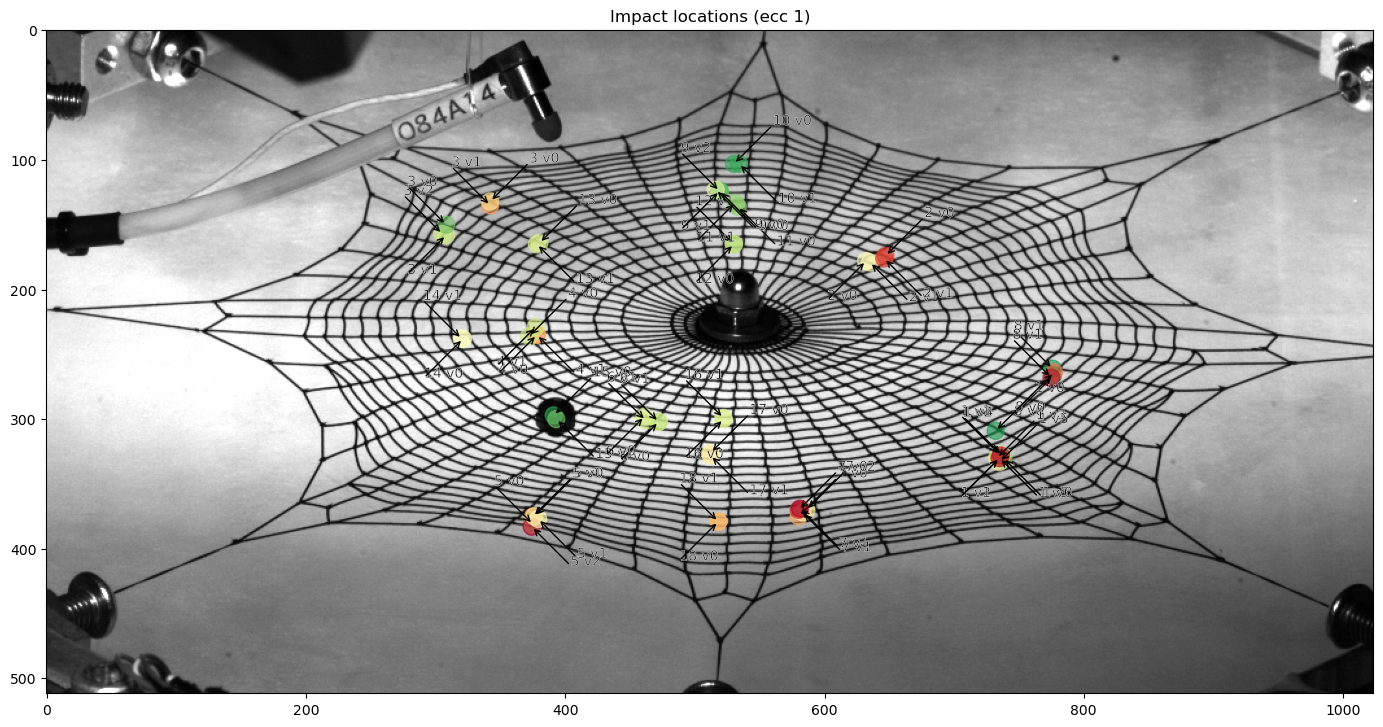

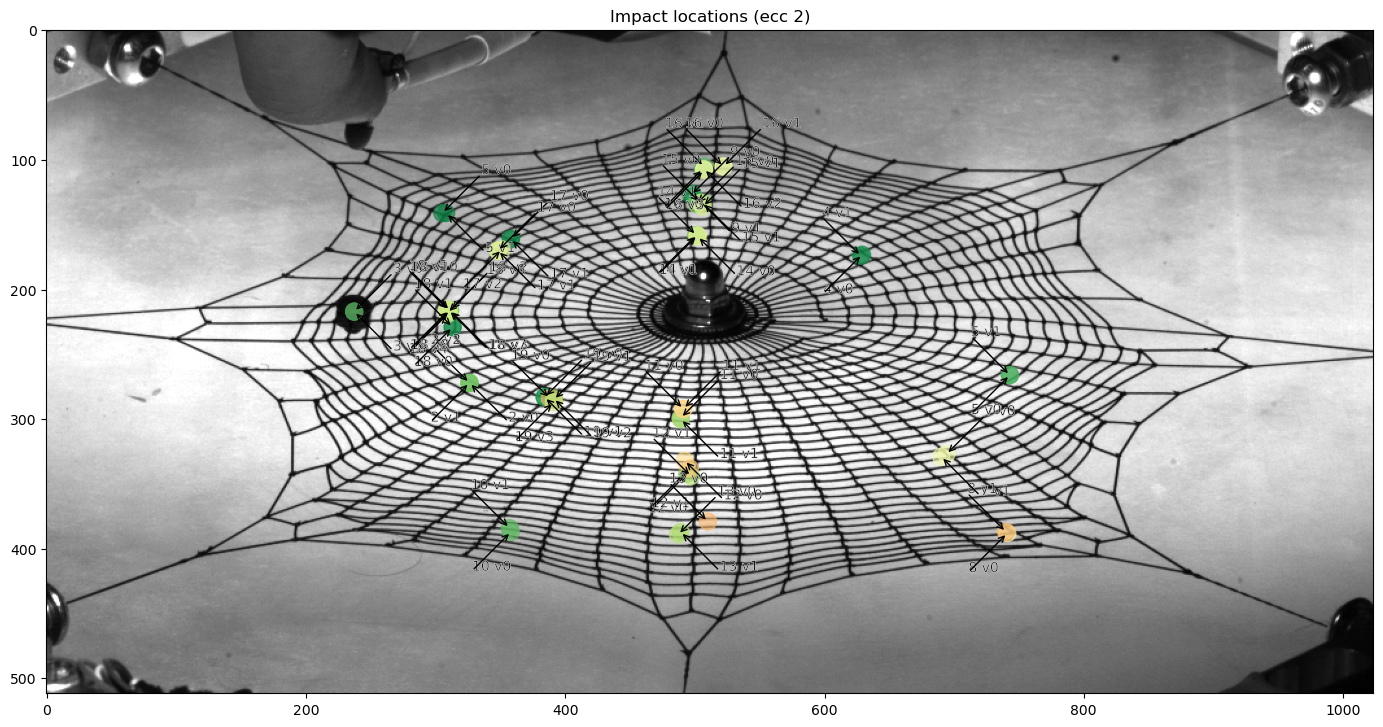

In [9]:
%matplotlib inline
root_drive_sim = os.path.normpath('G:/.shortcut-targets-by-id/1k1B8zPb3T8H7y6x0irFZnzzmfQPHMRPx/Illimited Lab Projects/Spiders/Simulations')
plot_fig_n = 4
shift_size = 30
shift = [np.array([shift_size,shift_size]), np.array([-shift_size,shift_size]), np.array([-shift_size,-shift_size]), np.array([shift_size,-shift_size])]
for ecc in range(3):
    df_filtered = df[(df['ecc'] == ecc) & (df['taut/loose'] == 'Loose') & (df['impact/pluck'] == 'Impact') & (df['mass'] == True) & (df['taut/loose'] == 'Loose')]
    undersaturated_pixels = df_filtered['Undersatured pixels']
    # oversaturated_pixels = df_filtered['Oversatured pixels']>30000
    # undersaturated_pixels[oversaturated_pixels] = 30000
    cmap = plt.get_cmap('RdYlGn_r')
    norm = plt.Normalize(vmin=10000, vmax=30000)
    colors = cmap(norm(undersaturated_pixels))
    path_name = df_filtered.iloc[plot_fig_n]['path']
    video = pyidi.pyIDI(path_name)
    still_image = video.mraw[0]

    # convert spider_ij to tuple
    spider_ij_global = np.array(eval(df_filtered.iloc[plot_fig_n]['spider_ij']))
    prey_ij = np.array(df_filtered['prey_ij'].apply(ast.literal_eval).tolist())
    spider_ij = np.array(df_filtered['spider_ij'].apply(ast.literal_eval).tolist())
    prey_ij = prey_ij - spider_ij + spider_ij_global
    # create the scatter plot
    fig, ax = plt.subplots(figsize=(14, 8))
    fig.tight_layout()
    ax.imshow(still_image, cmap='gray')
    scatter = ax.scatter(prey_ij[:,0],prey_ij[:,1], c=colors, alpha=0.6, norm=norm, cmap='RdYlGn_r', s=150)
    ax.set_title(f'Impact locations (ecc {ecc})')
    fig.savefig(os.path.join(root_drive_sim,'impact_locations','no_labels',f'impact_locations_ecc{ecc}.png'), dpi=300)
    for i, (loc, version) in enumerate(zip(df_filtered['loc'], df_filtered['version'])):
        ax.annotate(str(loc) + ' v' + str(version), prey_ij[i], xytext=prey_ij[i] + shift[i%4], fontsize=10, color='black', path_effects=[Stroke(linewidth=.3, foreground='white')])
        ax.annotate('', prey_ij[i], xytext=prey_ij[i] + shift[i%4], arrowprops=dict(arrowstyle='->', color='black'))
    fig.savefig(os.path.join(root_drive_sim,'impact_locations',f'impact_locations_ecc{ecc}_wlocs.png'), dpi=300)


In [ ]:
# df_data.append({'filename': file,
#                 'path': file_path,
#                 'ecc': n_ax, 
#                 'loc': n_loc,
#                 'mass': mass,
#                 'taut/loose': taut_loose, 
#                 'impact/pluck': impact_pluck, 
#                 'version': version, 
#                 'n_frames': n_frames,
#                 'fps': fps,
#                 'Oversatured pixels': white_indices_n,
#                 'Undersatured pixels': black_indices_n})
df_filtered = df[(df['ecc'] == 0) & (df['loc'] == 16) & (df['version'] == 0) & (df['impact/pluck'] == 'Impact') & (df['mass'] == True) & (df['taut/loose'] == 'Loose')]
path_name = df_filtered.iloc[0]['path']
print(path_name)
video = pyidi.pyIDI(path_name)
still_image = video.mraw[0]
# plot the still image
plt.imshow(still_image, cmap='gray')
prey_ij  = eval(df_filtered.iloc[0]['prey_ij'])
plt.plot(prey_ij[0], prey_ij[1], 'ro')
plt.show()
